In [55]:
%reload_ext autoreload
%autoreload 2
from __future__ import annotations
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler
from tqdm.notebook import tqdm
import session_info
import os
import warnings
import scanpy.external as sce
from metrics import *
import scprep
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
import magic
from activity import *
from pathlib import Path
from sklearn.preprocessing import StandardScaler  # Normal distribution.
from sklearn.preprocessing import MinMaxScaler    # [0,1] range.
from sklearn.preprocessing import Normalizer      # Unit norm.
from sklearn.feature_selection import VarianceThreshold
from scipy import stats


#!pip install ipywidgets --upgrade
os.environ["LOKY_MAX_CPU_COUNT"] = '4'
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
#Filtering warnings from current version of matplotlib.
warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)

In [56]:
# We first download the 68K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes.
adata = sc.datasets.pbmc68k_reduced()
adata.obs['labels'] = adata.obs.bulk_labels.map({'CD14+ Monocyte':0, 'Dendritic':1, 'CD56+ NK':2, 'CD4+/CD25 T Reg':3, 'CD19+ B':4, 'CD8+ Cytotoxic T':5, 'CD4+/CD45RO+ Memory':6, 'CD8+/CD45RA+ Naive Cytotoxic':7, 'CD4+/CD45RA+/CD25- Naive T':8, 'CD34+':9})
true_labels = adata.obs.labels
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'labels'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Run Magic

In [57]:
print(adata.raw.to_adata().X.toarray()[:5,:5])
sce.pp.magic(adata, name_list='all_genes')
print(adata.raw.to_adata().X[:5,:5])

[[0.    0.    0.    1.591 1.591]
 [1.55  0.    1.55  0.    0.   ]
 [0.    0.    1.374 0.    0.   ]
 [0.    0.    1.711 1.711 0.   ]
 [0.    0.    0.    1.275 0.   ]]
[[-0.326 -0.191 -0.728 -0.301  3.386]
 [ 1.171 -0.191  0.795 -1.2   -0.174]
 [-0.326 -0.191  0.483 -1.2   -0.174]
 [-0.326 -0.191  1.134 -0.157 -0.174]
 [-0.326 -0.191 -0.728 -0.607 -0.174]]


#### Retrieving gene sets
Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 

In [ ]:
# Retrieving gene sets. Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 
if not Path("./data/c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O './data/c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """Parse a gmt file to a decoupler pathway dataframe."""
    from itertools import chain, repeat

    pathways = {}
    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("./data/c2.cp.reactome.v7.5.1.symbols.gmt")
reactome.head()

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


In [60]:
def run_method(method_name, method):
    """Run a given method 30 times, calculate metrics and confidence intervals."""
    metrics = [[] for _ in range(6)] # Initialize 6 empty lists.
    metric_names = ['Silhouette', 'Calinski', 'Special', 'Completeness', 'Homogeneity', 'Adjusted']
    for _ in tqdm(range(30)):
        pathway_activity_df = method()
        #Perform KMeans clustering and plot UMAP.
        kmeans = cluster_with_kmeans(method_name, pathway_activity_df, adata, n_clusters=10)
        scores = calc_stats(pathway_activity_df, true_labels, kmeans.labels_, debug=False)
        for score, metric_list in zip(scores, metrics):
            metric_list.append(score)

    print(f'Results for {method_name}:')
    for name, metric in zip(metric_names, metrics):
        print(f"{name} - mean: {np.mean(metric)}, ci: {stats.t.interval(0.95, len(metric)-1, loc=np.mean(metric), scale=stats.sem(metric))}")

## GSEA

#### Running GSEA

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data. We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to calculate DE scores for each cell individually.

In [ ]:
# Running GSEA. We will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data.
# We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to 
# calculate DE scores for each cell individually.
def run_gsea():
    #Prepare the result matrix for GSEA scores.
    num_cells = adata.shape[0]
    num_gene_sets = len(reactome['geneset'].unique())
    gsea_results_matrix = np.zeros((num_cells, num_gene_sets))

    #Loop through each cell to run GSEA.
    for cell_index in range(num_cells):
        #Get normalized expression values for the specific cell.
        cell_expr = adata.X[cell_index]
        #Create a DataFrame to hold DE scores.
        de_scores = pd.DataFrame(cell_expr, index=adata.var_names, columns=['scores'])
        #Run GSEA using decoupler.
        _, norm, _ = decoupler.run_gsea(de_scores.T, reactome, source="geneset", target="genesymbol")
        #Store the normalized enrichment scores (NES) in the result matrix.
        gsea_results_matrix[cell_index, :] = norm.iloc[:, 0].values
        #Save the result matrix for later use.
        #np.save('./data/gsea_results_matrix.npy', gsea_results_matrix)
        print(cell_index, end='\r')
    return gsea_results_matrix


run_method('gsea', run_gsea)
'''
Silhouette Score: 0.5818618817999396
Calinski-Harabasz Index: 17819.743450336544
Special accuracy: 0.3314285714285714
completeness score: 0.22306129171029385
homogeneity_score: 0.2461920972304762
adjusted_mutual_info_score: 0.2096547513727912
'''

## PROGENy
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. Here is a brief description of each pathway:
- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [ ]:
progeny = decoupler.get_progeny(organism='human', top=2000)

def run_progeny():
    decoupler.run_mlm(mat=adata, net=progeny, source='source', target='target', weight='weight', verbose=False, use_raw=False)
    acts = decoupler.get_acts(adata, obsm_key='mlm_estimate')
    #Convert the pathway activity matrix to a DataFrame.
    return pd.DataFrame(acts.obsm['mlm_estimate'], index=adata.obs_names, columns=acts.var_names)

run_method('progeny', run_progeny)
'''
Silhouette - mean: 0.5994470119476318, ci: (0.5837380086204144, 0.6151560152748493)
Calinski - mean: 1809.87665776202, ci: (1773.4737280450795, 1846.2795874789604)
Special - mean: 0.6271428571428571, ci: (0.6114787182419504, 0.6428069960437638)
Completeness - mean: 0.6207960242943827, ci: (0.6128990147889134, 0.6286930337998521)
Homogeneity - mean: 0.6358791241359868, ci: (0.6309284707239026, 0.640829777548071)
Adjusted - mean: 0.6159252478430198, ci: (0.6098366484002805, 0.6220138472857591)
'''

100%|██████████| 30/30 [00:13<00:00,  2.15it/s]

Results for progeny:
Silhouette - mean: 0.5994470119476318, ci: (0.5837380086204144, 0.6151560152748493)
Calinski - mean: 1809.87665776202, ci: (1773.4737280450795, 1846.2795874789604)
Special - mean: 0.6271428571428571, ci: (0.6114787182419504, 0.6428069960437638)
Completeness - mean: 0.6207960242943827, ci: (0.6128990147889134, 0.6286930337998521)
Homogeneity - mean: 0.6358791241359868, ci: (0.6309284707239026, 0.640829777548071)
Adjusted - mean: 0.6159252478430198, ci: (0.6098366484002805, 0.6220138472857591)


## AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`. Make sure to run the previous cell for downloading the REACTOME gene sets.

In [ ]:
def run_aucell():
    decoupler.run_aucell(adata, reactome, source="geneset", target="genesymbol", use_raw=False, verbose=False)
    return adata.obsm["aucell_estimate"]

run_method('aucell', run_aucell)
'''
Silhouette - mean: 0.5645602345466614, ci: (0.5418287845709704, 0.5872916845223524)
Calinski - mean: 945.4906096018539, ci: (915.5391413815059, 975.4420778222018)
Special - mean: 0.5946666666666667, ci: (0.5827601074933282, 0.6065732258400052)
Completeness - mean: 0.60093050891257, ci: (0.5916599459964447, 0.6102010718286954)
Homogeneity - mean: 0.6342885403046792, ci: (0.6296686799647475, 0.6389084006446109)
Adjusted - mean: 0.6045281693242305, ci: (0.5974978431803457, 0.6115584954681152)
'''

100%|██████████| 30/30 [00:59<00:00,  1.97s/it]

Results for aucell:
Silhouette - mean: 0.5645602345466614, ci: (0.5418287845709704, 0.5872916845223524)
Calinski - mean: 945.4906096018539, ci: (915.5391413815059, 975.4420778222018)
Special - mean: 0.5946666666666667, ci: (0.5827601074933282, 0.6065732258400052)
Completeness - mean: 0.60093050891257, ci: (0.5916599459964447, 0.6102010718286954)
Homogeneity - mean: 0.6342885403046792, ci: (0.6296686799647475, 0.6389084006446109)
Adjusted - mean: 0.6045281693242305, ci: (0.5974978431803457, 0.6115584954681152)


## PathSingle

In [59]:
def run_pathsingle():
    from sklearn.decomposition import PCA
    
    activity_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    #magic_op = magic.MAGIC()
    #activity_df = magic_op.fit_transform(activity_df)
    activity = sc.AnnData(activity_df)

    calc_activity(activity)
    output_activity = pd.read_csv('./data/output_interaction_activity.csv', index_col=0)

    #selector = VarianceThreshold(threshold=0.01)
    #output_activity = selector.fit_transform(output_activity)

    #Scale the data.
    scaler = Normalizer()
    output_activity = scaler.fit_transform(output_activity)
    PCA = PCA(n_components=40, svd_solver='arpack')
    output_activity = PCA.fit_transform(output_activity)
    return output_activity

run_method('pathsingle', run_pathsingle)
'''
Results for pathsingle:
Silhouette - mean: 0.566888486138967, ci: (0.4813382043423624, 0.6524387679355717)
Calinski - mean: 1189.3883267574845, ci: (975.9591216967042, 1402.8175318182648)
Special - mean: 0.6747619047619048, ci: (0.6122458099689219, 0.7372779995548877)
Completeness - mean: 0.6489633720989917, ci: (0.617983027506479, 0.6799437166915043)
Homogeneity - mean: 0.6611417562907096, ci: (0.649123882635111, 0.6731596299463082)
Adjusted - mean: 0.6438135204333445, ci: (0.6253040693394939, 0.6623229715271951)
'''

  0%|          | 0/1 [00:00<?, ?it/s]

Results for pathsingle:0
Silhouette - mean: 0.5651534076997697, ci: (nan, nan)
Calinski - mean: 1236.9539216653636, ci: (nan, nan)
Special - mean: 0.62, ci: (nan, nan)
Completeness - mean: 0.6287088982196549, ci: (nan, nan)
Homogeneity - mean: 0.6471755700860252, ci: (nan, nan)
Adjusted - mean: 0.6259690164917309, ci: (nan, nan)


c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


'\nResults for pathsingle:\nSilhouette - mean: 0.566888486138967, ci: (0.4813382043423624, 0.6524387679355717)\nCalinski - mean: 1189.3883267574845, ci: (975.9591216967042, 1402.8175318182648)\nSpecial - mean: 0.6747619047619048, ci: (0.6122458099689219, 0.7372779995548877)\nCompleteness - mean: 0.6489633720989917, ci: (0.617983027506479, 0.6799437166915043)\nHomogeneity - mean: 0.6611417562907096, ci: (0.649123882635111, 0.6731596299463082)\nAdjusted - mean: 0.6438135204333445, ci: (0.6253040693394939, 0.6623229715271951)\n'

## Session info

In [3]:
sc.logging.print_versions()
session_info.show()

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
activity            NA
asttokens           NA
cffi                1.17.1
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
decoupler           1.7.0
deprecated          1.2.14
dill                0.3.8
exceptiongroup      1.2.1
executing           2.0.1
future              1.0.0
graphtools          1.5.3
h5py                3.11.0
igraph              0.11.6
importlib_resources NA
ipykernel           6.29.4
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.43.0
louvain             0.8.2
magic               3.0.0
matplotlib          3.9.0
matplotlib_inline   0.1.7
metrics             NA
mpl_toolkits        NA
natsort             8.4.0
nt                  NA
numba               0.6

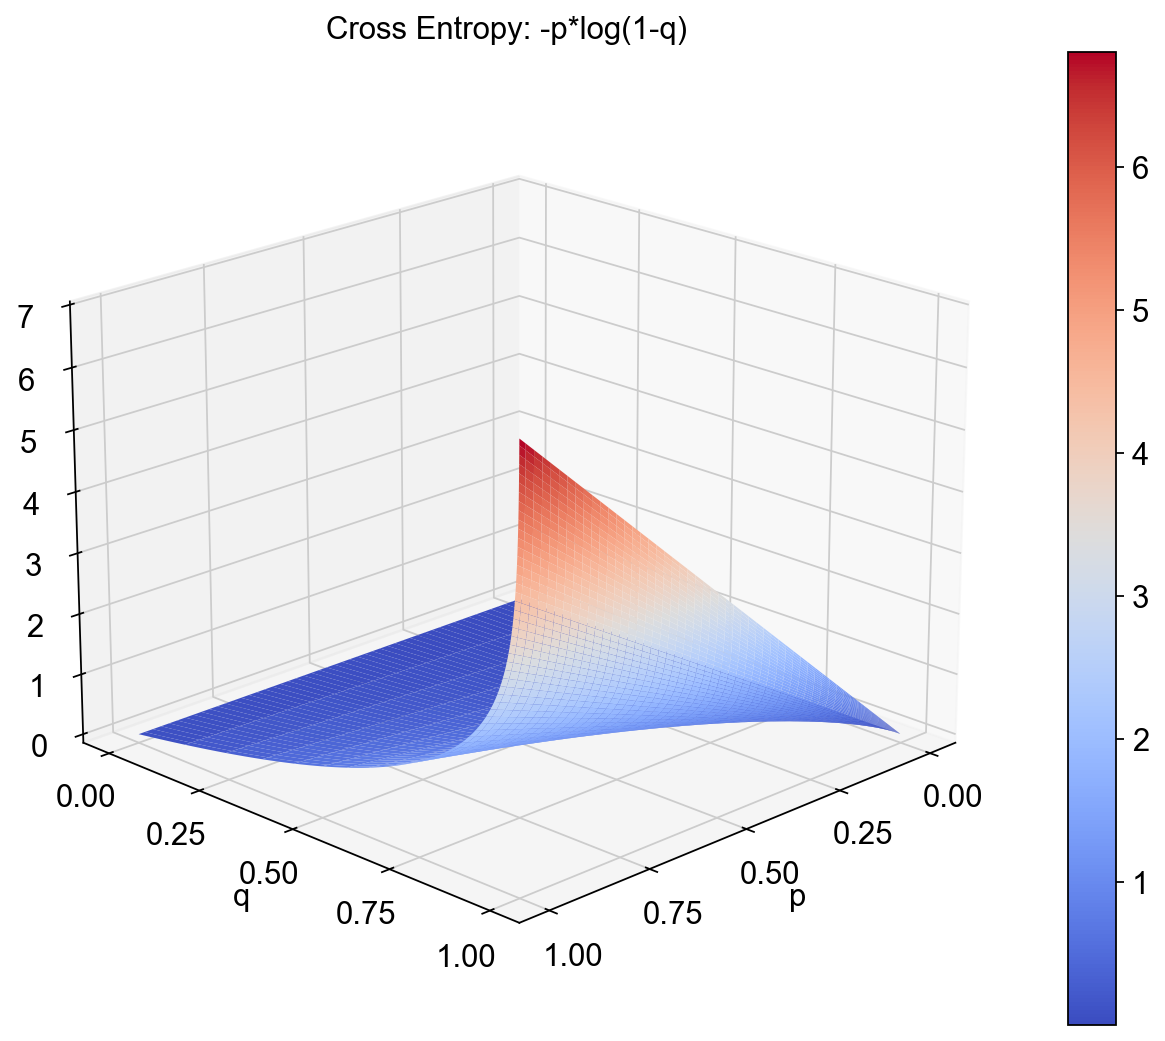

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create sample data.
p = np.linspace(0.001, 1, 200)  # Regular spacing.
#q = np.linspace(0.001, 1, 100)
q = 1 - np.logspace(-3, 0, 200)[::-1]  # More points near 1
P, Q = np.meshgrid(p, q)

# Calculate cross entropy.
cross_entropy = -P * np.log(1-Q)

# Create 3D plot.
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface with different colormap.
surf = ax.plot_surface(P, Q, cross_entropy, cmap='coolwarm') #cmap='viridis'

# Customize plot.
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Cross Entropy')
ax.view_init(elev=20, azim=45)  # Adjust viewing angle.
ax.set_xticks(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(0, 1, 5))

plt.colorbar(surf)
plt.title('Cross Entropy: -p*log(1-q)')
plt.show()

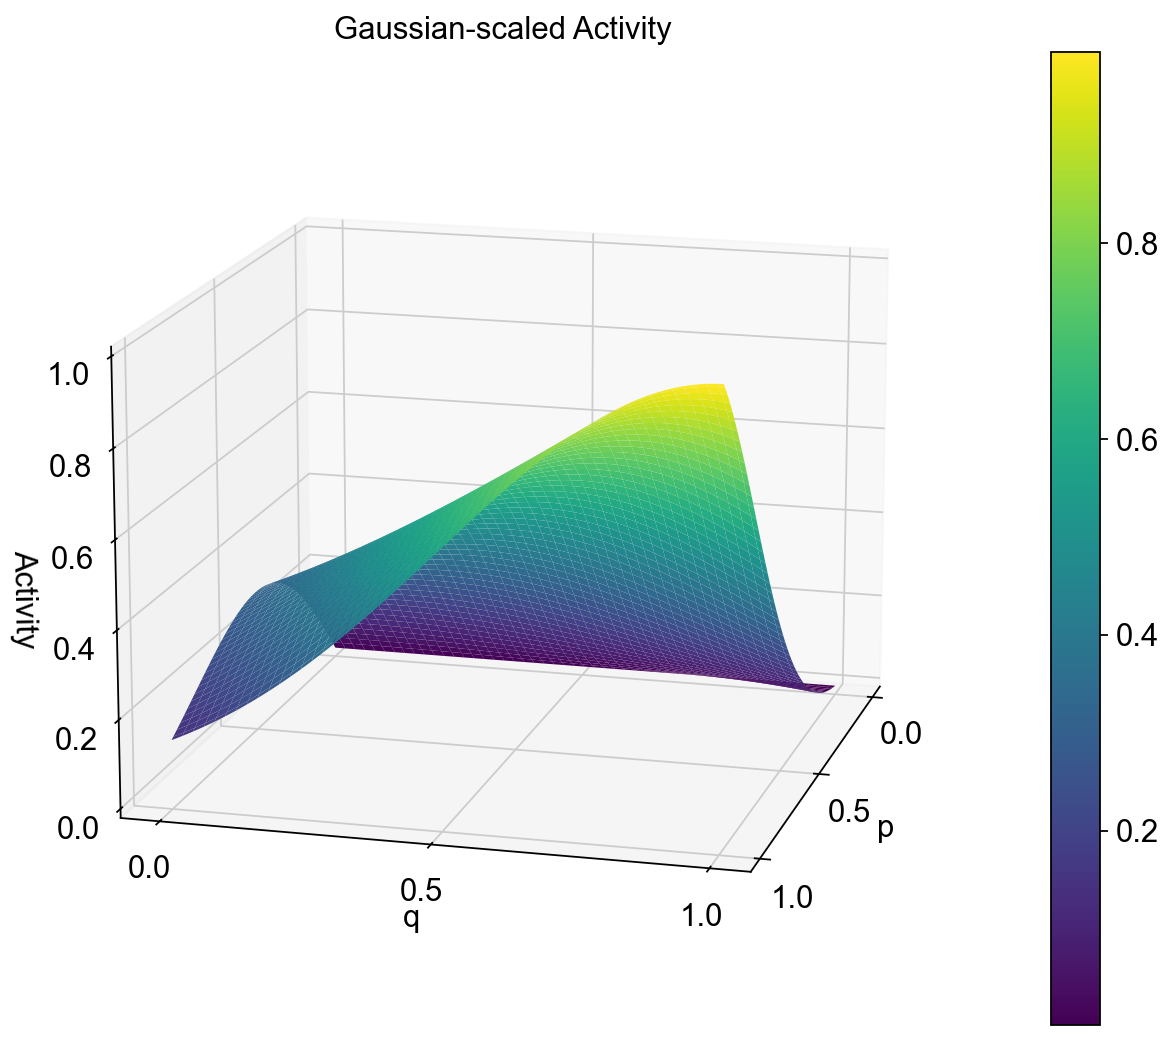

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_scaling(p, q, sigma=0.5):
    scaling = np.exp(-(p - q)**2 / (2*sigma**2))
    return p * scaling

# Create sample data.
p = np.linspace(0, 1, 100)
q = np.linspace(0, 1, 100)
P, Q = np.meshgrid(p, q)
Z = gaussian_scaling(P, Q)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P, Q, Z, cmap='viridis')

# Customize plot.
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Activity')
ax.view_init(elev=15, azim=15)  # Adjust viewing angle.
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])

plt.colorbar(surf)
plt.title('Gaussian-scaled Activity')
plt.show()